In [67]:
import mne
from pathlib import Path
data_path = r"data\konrad-real_movement\KONRAD-4_ruszanie_run1_20251202_205706_raw_cropped.fif"
recording_name = Path(data_path).stem
is_real_movement = "real" in data_path.lower()
recording_type = "real_movement" if is_real_movement else "motor_imagery"

raw = mne.io.read_raw_fif(data_path, preload=True)
eeg_channels = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16"]
raw.pick(picks=eeg_channels)
raw.resample(sfreq=250)
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')
raw.notch_filter(freqs=[50.0])

konrad_mapping = {
    'A1': 'Cz',
    'A2': 'FCz',
    'A3': 'CP1',
    'A4': 'FC1',
    'A5': 'C1',
    'A6': 'CP3',
    'A7': 'C3',
    'A8': 'FC3',
    'A9': 'C4',
    'A10': 'FC4',
    'A11': 'Pz',
    'A12': 'CP2',
    'A13': 'CP4',
    'A14': 'C2',    
    'A15': 'CPz',
    'A16': 'FC2'
}

raw.rename_channels(konrad_mapping)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

all_events, all_events_id = mne.events_from_annotations(raw)
all_events_id = {"relax": 1, "left_hand": 2, "right_hand": 3, "both_hands": 4, "both_feets": 5}

task_margin = 1.0 # event is when cue is shown
task_duration = 5.0
task_end = task_margin + task_duration

reject_criteria = dict(
    eeg=80e-6,  # 80 µV
) 

epochs = mne.Epochs(
    raw=raw,
    events=all_events,
    event_id=all_events_id,
    baseline=None,
    tmin=task_margin,
    tmax=task_end,
    preload=True,
    reject=reject_criteria
)

pass

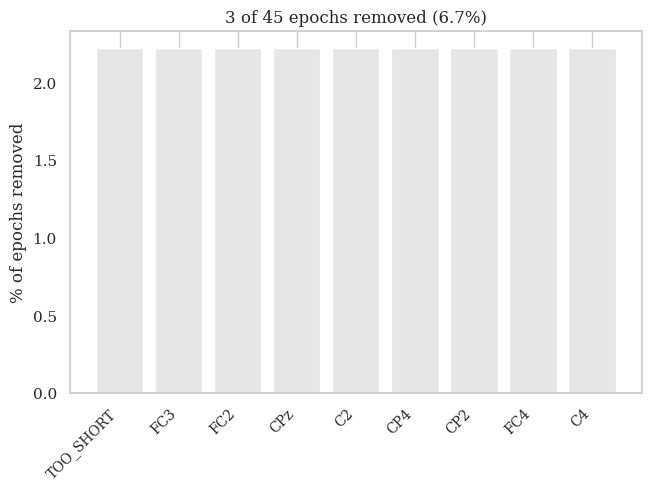

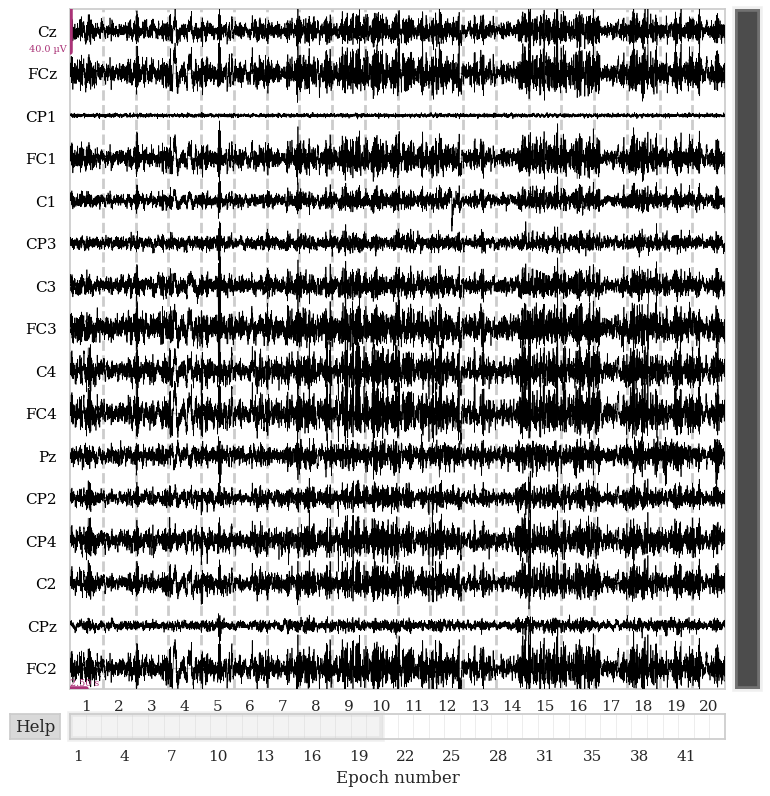

In [68]:
epochs.plot_drop_log()
epochs.plot()
pass

In [69]:
import os
import numpy as np
import mne
from moabb.datasets.base import BaseDataset

class BrainBotDataset(BaseDataset):
    def __init__(self, data_dir, subjects, events, interval, data_names, sessions_per_subject):
        """
        Parameters
        ----------
        data_dir : str
            Path to the directory containing the data files.
        subjects : list
            List of subject identifiers.
        events : dict
            Dictionary mapping event names to event IDs.
        interval : list
            Time interval for epochs.
        data_names : dict
            Dictionary mapping subject identifiers to their corresponding data file names (can be multiple runs).
        sessions_per_subject : int
            Number of sessions per subject.
        """
        super().__init__(
            subjects=subjects,
            sessions_per_subject=sessions_per_subject,
            events=events,
            code="BrainBot",
            interval=interval,
            paradigm="imagery",
        )
        self.data_dir = data_dir
        self.data_names = data_names

    def data_path(self, subject, path=None, force_update=False, update_path=None, verbose=None):
        base = self.data_dir
        filenames = self.data_names[subject]
        epochs_files = [os.path.join(base, fname) for fname in filenames]
        return epochs_files

    def _get_single_subject_data(self, subject):
        paths = self.data_path(subject)
        sessions = {"0": {}} # sessions->runs->raw
        for i, path in enumerate(paths):
            epochs = mne.read_epochs(path, preload=True)
            data = epochs.get_data()
            n_epochs, n_ch, n_times = data.shape
            data_flat = data.transpose(1, 0, 2).reshape(n_ch, n_epochs * n_times)

            # create stim channel for moabb compatibility
            stim = np.zeros(n_epochs * n_times, dtype=int)
            for i, ev in enumerate(epochs.events):
                sample = i * n_times
                stim[sample] = int(ev[2])
            data_with_stim = np.vstack([data_flat, stim])

            sfreq = epochs.info['sfreq']
            ch_names = epochs.ch_names + ['stim']
            ch_types = ['eeg'] * n_ch + ['stim']
            info = mne.create_info(ch_names, sfreq, ch_types)
            raw = mne.io.RawArray(data_with_stim, info)
            sessions["0"][str(i)] = raw
        
        return sessions

dataset = BrainBotDataset(
    data_dir="data/processed/",
    subjects=[0], # 0 - konrad, 1 - hania, 2 - mati
    events=epochs.event_id,
    interval=[0.0, 2.0],
    data_names={
        0: [
            "KONRAD-1_sciskanie_run1_20251202_194514_raw_epochs_splitted_segment=2.0-step=1.0-epo.fif",
            "KONRAD-2_sciskanie_run1_20251202_203846_raw_epochs_splitted_segment=2.0-step=1.0-epo.fif",
            "KONRAD-3_sciskanie+ruszanie_run1_20251202_204816_raw_epochs_splitted_segment=2.0-step=1.0-epo.fif",
            "KONRAD-4_ruszanie_run1_20251202_205706_raw_cropped_epochs_splitted_segment=2.0-step=1.0-epo.fif",
        ],
        1: [
            'hania_imagery_movement_1_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'hania_imagery_movement_2_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'hania_imagery_movement_2_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif', # X: repeated to have 3 sessions      
        ],
        2: [
            'mati_test_imagery_movement_1_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'mati_test_imagery_movement_2_squeezing_ball_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'mati_test_imagery_movement_3_lifting_fingers_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
        ],
    },
    sessions_per_subject=1,
)

In [70]:
from moabb.datasets import BNCI2014_001, PhysionetMI, Schirrmeister2017, Zhou2016
from moabb.paradigms import MotorImagery, LeftRightImagery
from moabb.evaluations import WithinSessionEvaluation

from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

import moabb

moabb.set_log_level('ERROR')
mne.set_log_level('ERROR')

datasets = [dataset]
paradigm = MotorImagery(n_classes=4, events=["relax", "left_hand", "right_hand", "both_feets"]) # LeftRightImagery()

# Base classifiers and preprocessing
svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True))
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipelines = {}
# Keep original pipelines for reference
pipelines['CSP + SVM'] = make_pipeline(csp, svm)
pipelines['CSP + LDA'] = make_pipeline(CSP(n_components=8), LinearDiscriminantAnalysis())

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# TGSP (Riemannian) pipeline
pipelines['TGSP + SVM'] = make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"), SVC(kernel="linear", probability=True))

# Calibrate SVM (wrap OneVsRestClassifier). Calibration improves predict_proba quality for voting/stacking
calibrated_svm = CalibratedClassifierCV(estimator=OneVsRestClassifier(SVC(kernel='rbf', probability=True)), cv=3)
pipelines['CSP + SVM (Cal)'] = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False), calibrated_svm)
pipelines['TGSP + SVM (Cal)'] = make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"), CalibratedClassifierCV(estimator=SVC(kernel="linear", probability=True), cv=3))

# Build explicit ordered list of base estimators for ensembles
base_estimators = [
    ('csp_svm_cal', pipelines['CSP + SVM (Cal)']),
    ('csp_lda', pipelines['CSP + LDA']),
    ('tgsp_svm_cal', pipelines['TGSP + SVM (Cal)']),
]

# Weighted voting: favor the stronger models
voting = VotingClassifier(estimators=base_estimators, voting='soft', weights=[1, 2, 2])
pipelines['Ensemble (Weighted)'] = voting

# Stacking with a regularized meta-learner (smaller C => stronger regularization)
stacking = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(C=0.1, max_iter=1000), cv=5, stack_method='predict_proba')
pipelines['Stacking (All+RegLR)'] = stacking

evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=True)
results = evaluation.process(pipelines)

BrainBot-WithinSession:   0%|          | 0/1 [00:00<?, ?it/s]D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 158 events (all good), 0 – 2 s (baseline off), ~9.7 MiB, data loaded,
 'relax': 39
 'left_hand': 40
 'right_hand': 40
 'both_feets': 39>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 154 events (all good), 0 – 2 s (baseline off), ~9.4 MiB, data loaded,
 'relax': 39
 'left_hand': 36
 'right_hand': 40
 'both_feets': 39>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 138 events (all good), 0 – 2 s (baseline off), ~8.5 MiB, data loaded,
 'relax': 31
 'left_hand': 36
 'right_hand': 36
 'both_feets': 35>
  warn(f"warnEpochs {epochs}")


No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.


BrainBot-WithinSession: 100%|██████████| 1/1 [00:49<00:00, 49.06s/it]


In [71]:
print(results)
print(dataset.get_data())

      score      time  samples subject session  channels  n_sessions  \
0  0.664444  0.319981    450.0       0       0        16           1   
1  0.615556  0.357648    450.0       0       0        16           1   
2  0.551111  6.250660    450.0       0       0        16           1   
3  0.526667  0.389734    450.0       0       0        16           1   
4  0.577778  1.143902    450.0       0       0        16           1   
5  0.537778  0.467987    450.0       0       0        16           1   
6  0.540000  0.357945    450.0       0       0        16           1   

    dataset              pipeline  
0  BrainBot            TGSP + SVM  
1  BrainBot      TGSP + SVM (Cal)  
2  BrainBot  Stacking (All+RegLR)  
3  BrainBot             CSP + SVM  
4  BrainBot   Ensemble (Weighted)  
5  BrainBot       CSP + SVM (Cal)  
6  BrainBot             CSP + LDA  
{0: {'0': {'199': <RawArray | 17 x 100000 (400.0 s), ~13.0 MiB, data loaded>, '195': <RawArray | 17 x 98000 (392.0 s), ~12.7 MiB, data 

In [72]:
print("Results Summary:")
summary = results.groupby(['pipeline', 'dataset'])['score'].agg(['mean', 'std', 'count'])
summary['mean'] = summary['mean'].round(3)
summary['std'] = summary['std'].round(3)
print(summary.to_string())
print("=" * 50)

print("\nDetailed Results by Subject and Dataset:")
detailed = results.pivot_table(
    index=['dataset', 'subject', 'session'], 
    columns='pipeline', 
    values='score'
)
print(detailed.round(3).to_string())
print("=" * 50)

Results Summary:
                                mean  std  count
pipeline             dataset                    
CSP + LDA            BrainBot  0.540  NaN      1
CSP + SVM            BrainBot  0.527  NaN      1
CSP + SVM (Cal)      BrainBot  0.538  NaN      1
Ensemble (Weighted)  BrainBot  0.578  NaN      1
Stacking (All+RegLR) BrainBot  0.551  NaN      1
TGSP + SVM           BrainBot  0.664  NaN      1
TGSP + SVM (Cal)     BrainBot  0.616  NaN      1

Detailed Results by Subject and Dataset:
pipeline                  CSP + LDA  CSP + SVM  CSP + SVM (Cal)  Ensemble (Weighted)  Stacking (All+RegLR)  TGSP + SVM  TGSP + SVM (Cal)
dataset  subject session                                                                                                                
BrainBot 0       0             0.54      0.527            0.538                0.578                 0.551       0.664             0.616


## Confusion Matrices from Individual Predictions

Now let's re-run the evaluation with `save_predictions=True` to collect per-sample predictions for confusion matrices

In [73]:
# Re-run evaluation with save_predictions enabled
evaluation_with_pred = WithinSessionEvaluation(
    paradigm=paradigm, 
    datasets=datasets, 
    hdf5_path="results_with_predictions.h5",  # Use different file to preserve original results
    overwrite=True,
    save_predictions=True  # Enable per-sample prediction storage
)
results_with_pred = evaluation_with_pred.process(pipelines)
print("Evaluation complete with predictions saved!")
print(results_with_pred)

BrainBot-WithinSession:   0%|          | 0/1 [00:00<?, ?it/s]D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 158 events (all good), 0 – 2 s (baseline off), ~9.7 MiB, data loaded,
 'relax': 39
 'left_hand': 40
 'right_hand': 40
 'both_feets': 39>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 154 events (all good), 0 – 2 s (baseline off), ~9.4 MiB, data loaded,
 'relax': 39
 'left_hand': 36
 'right_hand': 40
 'both_feets': 39>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 138 events (all good), 0 – 2 s (baseline off), ~8.5 MiB, data loaded,
 'relax': 31
 'left_hand': 36
 'right_hand': 36
 'both_feets': 35>
  warn(f"warnEpochs {epochs}")
BrainBot-WithinSession: 100%|██████████| 1/1 [00:53<00:00, 53.85s/it]


Evaluation complete with predictions saved!
      score      time  samples subject session  channels  n_sessions  \
0  0.626667  0.458083    450.0       0       0        16           1   
1  0.635556  0.485272    450.0       0       0        16           1   
2  0.546667  6.568308    450.0       0       0        16           1   
3  0.531111  0.410985    450.0       0       0        16           1   
4  0.586667  1.342793    450.0       0       0        16           1   
5  0.533333  0.567803    450.0       0       0        16           1   
6  0.544444  0.366027    450.0       0       0        16           1   

    dataset              pipeline  
0  BrainBot            TGSP + SVM  
1  BrainBot      TGSP + SVM (Cal)  
2  BrainBot  Stacking (All+RegLR)  
3  BrainBot             CSP + SVM  
4  BrainBot   Ensemble (Weighted)  
5  BrainBot       CSP + SVM (Cal)  
6  BrainBot             CSP + LDA  



Pipeline: CSP + SVM
Subject 0, Session 0: 450 samples


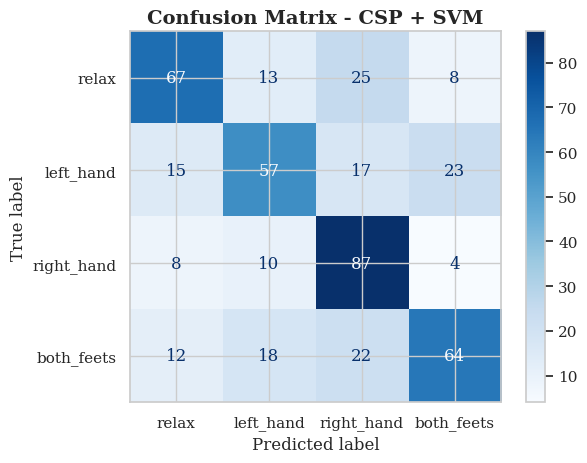


Confusion Matrix for CSP + SVM:
[[67 13 25  8]
 [15 57 17 23]
 [ 8 10 87  4]
 [12 18 22 64]]
Accuracy: 0.6111

Pipeline: CSP + LDA
Subject 0, Session 0: 450 samples


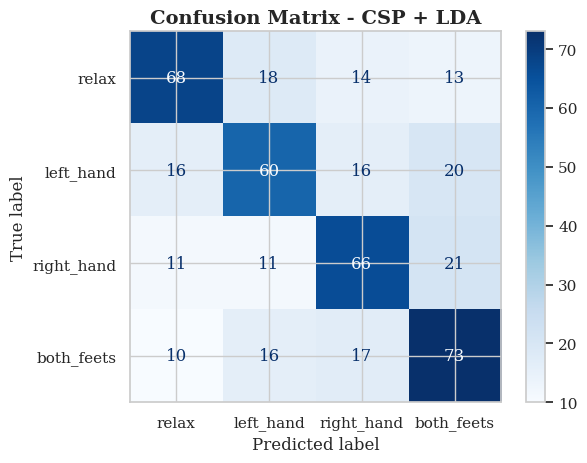


Confusion Matrix for CSP + LDA:
[[68 18 14 13]
 [16 60 16 20]
 [11 11 66 21]
 [10 16 17 73]]
Accuracy: 0.5933

Pipeline: TGSP + SVM
Subject 0, Session 0: 450 samples


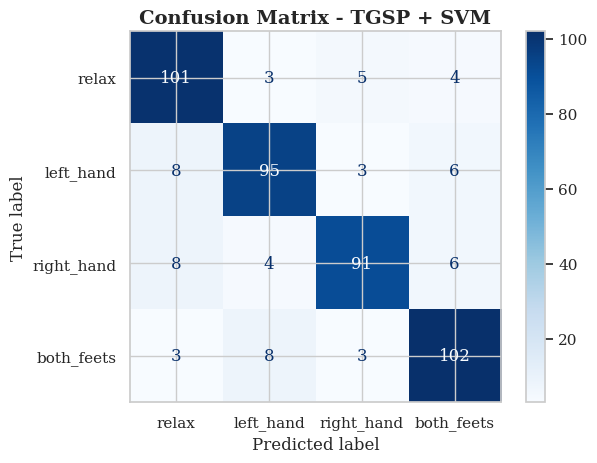


Confusion Matrix for TGSP + SVM:
[[101   3   5   4]
 [  8  95   3   6]
 [  8   4  91   6]
 [  3   8   3 102]]
Accuracy: 0.8644

Pipeline: CSP + SVM (Cal)
Subject 0, Session 0: 450 samples


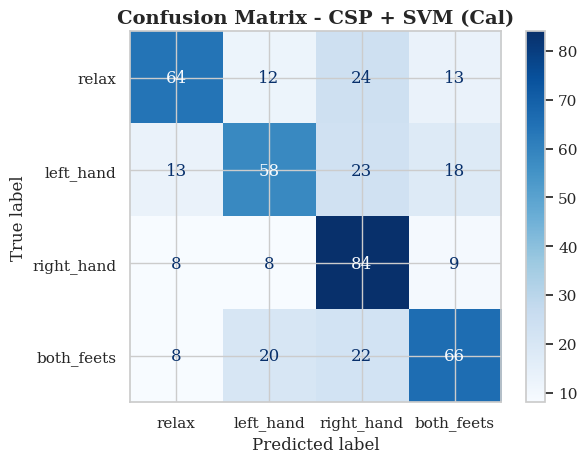


Confusion Matrix for CSP + SVM (Cal):
[[64 12 24 13]
 [13 58 23 18]
 [ 8  8 84  9]
 [ 8 20 22 66]]
Accuracy: 0.6044

Pipeline: TGSP + SVM (Cal)
Subject 0, Session 0: 450 samples


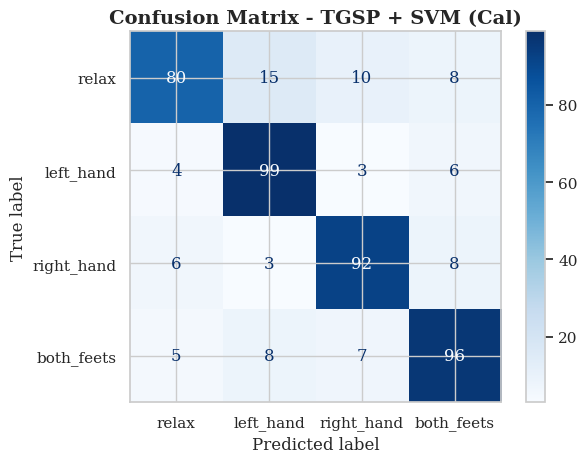


Confusion Matrix for TGSP + SVM (Cal):
[[80 15 10  8]
 [ 4 99  3  6]
 [ 6  3 92  8]
 [ 5  8  7 96]]
Accuracy: 0.8156

Pipeline: Ensemble (Weighted)
Subject 0, Session 0: 450 samples


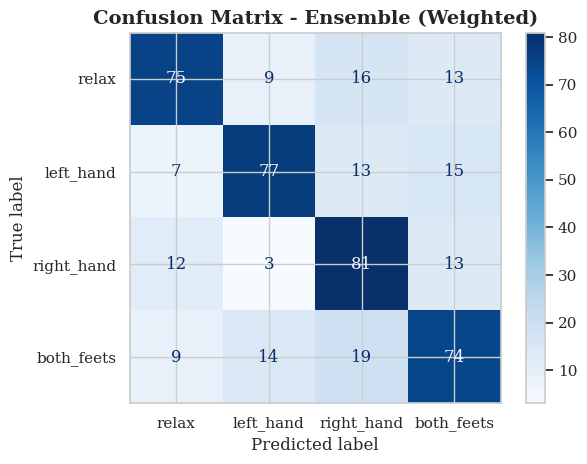


Confusion Matrix for Ensemble (Weighted):
[[75  9 16 13]
 [ 7 77 13 15]
 [12  3 81 13]
 [ 9 14 19 74]]
Accuracy: 0.6822

Pipeline: Stacking (All+RegLR)
Subject 0, Session 0: 450 samples


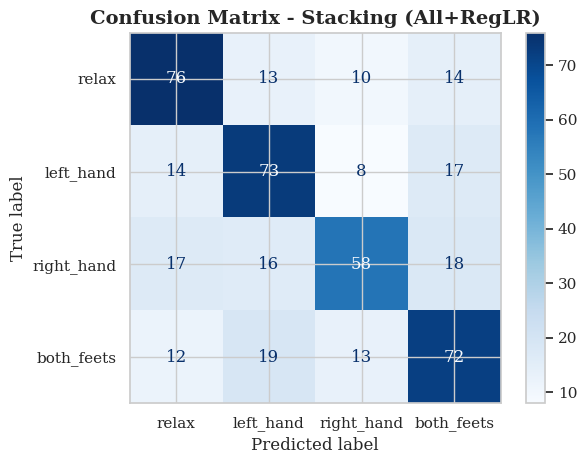


Confusion Matrix for Stacking (All+RegLR):
[[76 13 10 14]
 [14 73  8 17]
 [17 16 58 18]
 [12 19 13 72]]
Accuracy: 0.6200


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Use paradigm events (which filters to relevant classes), not dataset events
paradigm_class_labels = paradigm.events  # ['left_hand', 'right_hand']
paradigm_class_ids = list(range(len(paradigm_class_labels)))  # [0, 1]

# Create confusion matrices for each pipeline and subject combination
for pipeline_name in pipelines.keys():
    print(f"\n{'='*60}")
    print(f"Pipeline: {pipeline_name}")
    print(f"{'='*60}")
    
    all_y_true = []
    all_y_pred = []
    
    # Collect predictions from all subjects/sessions
    for subject in dataset.subject_list:
        for session_idx in range(dataset.n_sessions):
            session_name = str(session_idx)
            
            try:
                predictions = evaluation_with_pred.results.get_predictions(
                    dataset_code=dataset.code,
                    subject=subject,
                    session=session_name,
                    pipeline_name=pipeline_name
                )
                
                if predictions is not None:
                    all_y_true.extend(predictions['y_true'])
                    all_y_pred.extend(predictions['y_pred'])
                    print(f"Subject {subject}, Session {session_name}: {len(predictions['y_true'])} samples")
            except Exception as e:
                print(f"Could not retrieve predictions for Subject {subject}, Session {session_name}: {str(e)}")
    
    if len(all_y_true) > 0:
        # Create confusion matrix using PARADIGM events (0-indexed)
        cm = confusion_matrix(all_y_true, all_y_pred, labels=paradigm_class_ids)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=paradigm_class_labels)
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f'Confusion Matrix - {pipeline_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\nConfusion Matrix for {pipeline_name}:")
        print(cm)
        print(f"Accuracy: {np.trace(cm) / np.sum(cm):.4f}")
    else:
        print(f"No predictions found for pipeline {pipeline_name}")

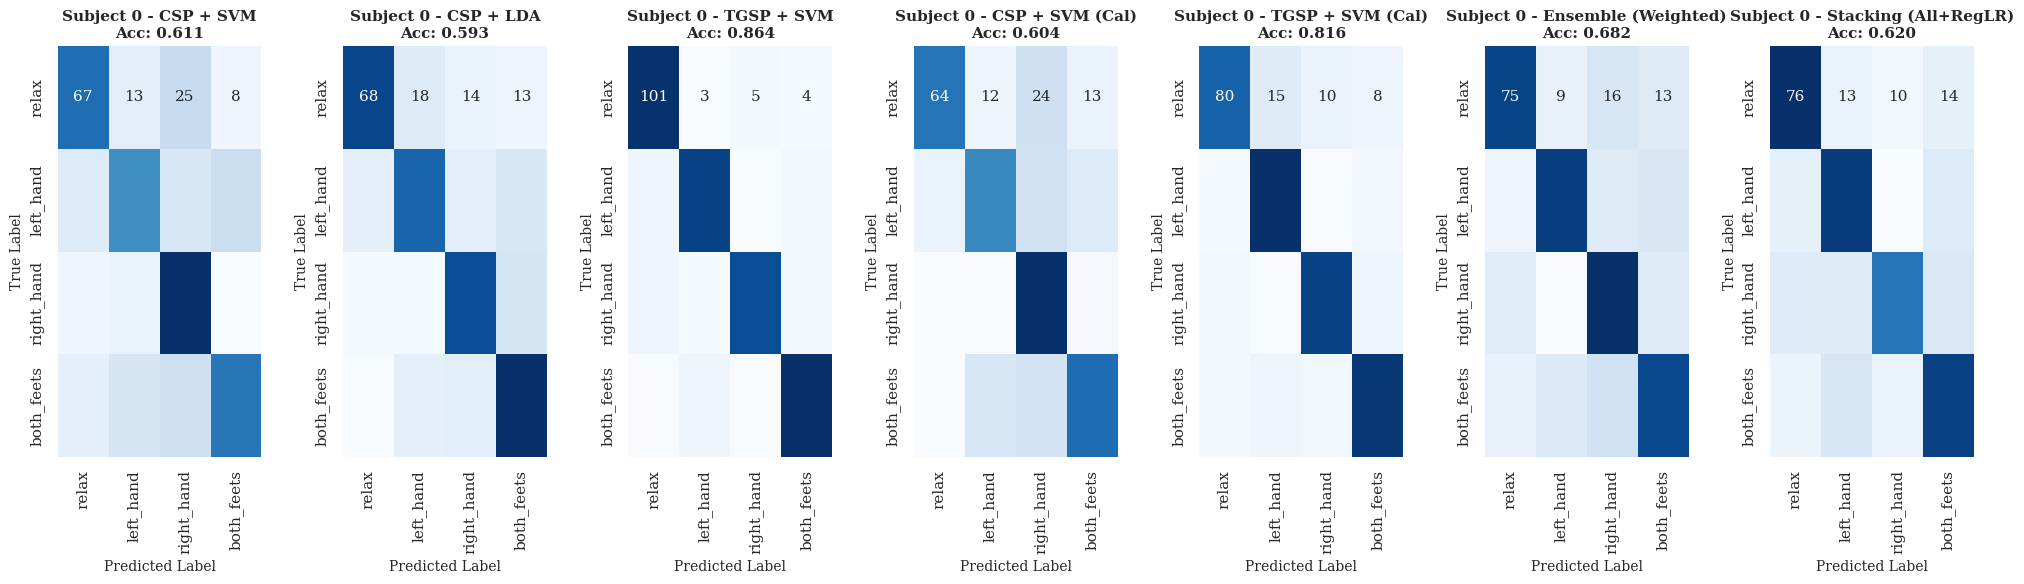

Per-subject confusion matrices created!


In [75]:
paradigm_class_labels = paradigm.events
paradigm_class_ids = list(range(len(paradigm_class_labels)))

fig, axes = plt.subplots(len(dataset.subject_list), len(pipelines), 
                         figsize=(20, 6*len(dataset.subject_list)))

if len(dataset.subject_list) == 1:
    axes = axes.reshape(1, -1)
elif len(pipelines) == 1:
    axes = axes.reshape(-1, 1)

for subject_idx, subject in enumerate(dataset.subject_list):
    for pipeline_idx, pipeline_name in enumerate(pipelines.keys()):
        try:
            predictions = evaluation_with_pred.results.get_predictions(
                dataset_code=dataset.code,
                subject=subject,
                session="0",
                pipeline_name=pipeline_name
            )
            
            if predictions is not None:
                cm = confusion_matrix(predictions['y_true'], predictions['y_pred'], 
                                    labels=paradigm_class_ids)
                ax = axes[subject_idx, pipeline_idx]
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                           xticklabels=paradigm_class_labels, yticklabels=paradigm_class_labels,
                           ax=ax, cbar=False, annot_kws={'size': 11})

                accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0
                ax.set_title(f'Subject {subject} - {pipeline_name}\nAcc: {accuracy:.3f}', 
                            fontsize=11, fontweight='bold')
                ax.set_ylabel('True Label', fontsize=10)
                ax.set_xlabel('Predicted Label', fontsize=10)
        except Exception as e:
            ax = axes[subject_idx, pipeline_idx]
            ax.text(0.5, 0.5, f'No data\nfor {pipeline_name}', 
                   ha='center', va='center', fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

print("Per-subject confusion matrices created!")

## Detailed Analysis with Per-Fold Metrics

Extract fold-specific information to analyze model consistency across folds

In [76]:
# Analyze per-fold consistency
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

print("\n" + "="*80)
print("PER-FOLD ANALYSIS - Model Consistency Across Cross-Validation Folds")
print("="*80)

for pipeline_name in pipelines.keys():
    print(f"\n{pipeline_name}")
    print("-" * 80)
    
    for subject in dataset.subject_list:
        try:
            predictions = evaluation_with_pred.results.get_predictions(
                dataset_code=dataset.code,
                subject=subject,
                session="0",
                pipeline_name=pipeline_name
            )
            
            if predictions is not None:
                y_true = predictions['y_true']
                y_pred = predictions['y_pred']
                y_proba = predictions.get('y_proba', None)
                fold_ids = predictions.get('fold_id', np.zeros(len(y_true), dtype=int))
                
                print(f"\n  Subject {subject}:")
                
                # Overall metrics
                overall_acc = accuracy_score(y_true, y_pred)
                overall_balanced_acc = balanced_accuracy_score(y_true, y_pred)
                overall_f1 = f1_score(y_true, y_pred, average='weighted')
                
                # Calculate ROC-AUC if probabilities are available
                overall_roc_auc = None
                if y_proba is not None and len(y_proba) > 0:
                    try:
                        y_proba_array = np.asarray(y_proba)
                        if y_proba_array.size > 0:
                            # Handle different probability shapes
                            if len(y_proba_array.shape) == 1:
                                # Single probability value per sample
                                overall_roc_auc = roc_auc_score(y_true, y_proba_array)
                            else:
                                # Multiple class probabilities - use one-vs-rest
                                overall_roc_auc = roc_auc_score(y_true, y_proba_array, multi_class='ovr', average='weighted')
                    except Exception as e:
                        pass
                
                if overall_roc_auc is not None:
                    print(f"    Overall - Acc: {overall_acc:.4f}, Balanced Acc: {overall_balanced_acc:.4f}, F1: {overall_f1:.4f}, ROC-AUC: {overall_roc_auc:.4f}")
                else:
                    print(f"    Overall - Acc: {overall_acc:.4f}, Balanced Acc: {overall_balanced_acc:.4f}, F1: {overall_f1:.4f}, ROC-AUC: N/A")
                
                # Per-fold metrics
                if isinstance(fold_ids, np.ndarray) and len(np.unique(fold_ids)) > 1:
                    print(f"    Per-fold metrics:")
                    for fold in sorted(np.unique(fold_ids)):
                        if fold >= 0:  # Skip invalid fold markers
                            mask = fold_ids == fold
                            fold_acc = accuracy_score(y_true[mask], y_pred[mask])
                            fold_samples = np.sum(mask)
                            
                            # ROC-AUC per fold
                            fold_roc_auc = None
                            if y_proba is not None and len(y_proba) > 0:
                                try:
                                    y_proba_fold = np.asarray(y_proba)[mask]
                                    if y_proba_fold.size > 0:
                                        if len(y_proba_fold.shape) == 1:
                                            fold_roc_auc = roc_auc_score(y_true[mask], y_proba_fold)
                                        else:
                                            fold_roc_auc = roc_auc_score(y_true[mask], y_proba_fold, multi_class='ovr', average='weighted')
                                except Exception as e:
                                    pass
                            
                            if fold_roc_auc is not None:
                                print(f"      Fold {int(fold)}: Acc: {fold_acc:.4f}, ROC-AUC: {fold_roc_auc:.4f} (n={fold_samples})")
                            else:
                                print(f"      Fold {int(fold)}: Acc: {fold_acc:.4f}, ROC-AUC: N/A (n={fold_samples})")
        except Exception as e:
            print(f"  Could not analyze Subject {subject}: {str(e)}")


PER-FOLD ANALYSIS - Model Consistency Across Cross-Validation Folds

CSP + SVM
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.6111, Balanced Acc: 0.6129, F1: 0.6072, ROC-AUC: N/A

CSP + LDA
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.5933, Balanced Acc: 0.5931, F1: 0.5932, ROC-AUC: N/A

TGSP + SVM
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8644, Balanced Acc: 0.8640, F1: 0.8644, ROC-AUC: N/A

CSP + SVM (Cal)
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.6044, Balanced Acc: 0.6060, F1: 0.6021, ROC-AUC: N/A

TGSP + SVM (Cal)
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8156, Balanced Acc: 0.8159, F1: 0.8143, ROC-AUC: N/A

Ensemble (Weight